<a href="https://colab.research.google.com/github/maruwrks/Deep-Learning-Task/blob/main/CNN_FishImgDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic CNN

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

In [ ]:
dataset = 'C:/Users/Maru/Documents/FishImgDataset'
train_dir = os.path.join(dataset, 'train')
val_dir = os.path.join(dataset, 'val')
test_dir = os.path.join(dataset, 'test')

In [ ]:
IMAGE_SIZE = (32,32)
BATCH_SIZE = 32

In [ ]:
class_names = sorted(os.listdir(train_dir))
num_classes = len(class_names)
print(f"Total classes: {num_classes}")
print(f"Class names: {class_names}")

Total classes: 31
Class names: ['Bangus', 'Big Head Carp', 'Black Spotted Barb', 'Catfish', 'Climbing Perch', 'Fourfinger Threadfin', 'Freshwater Eel', 'Glass Perchlet', 'Goby', 'Gold Fish', 'Gourami', 'Grass Carp', 'Green Spotted Puffer', 'Indian Carp', 'Indo-Pacific Tarpon', 'Jaguar Gapote', 'Janitor Fish', 'Knifefish', 'Long-Snouted Pipefish', 'Mosquito Fish', 'Mudfish', 'Mullet', 'Pangasius', 'Perch', 'Scat Fish', 'Silver Barb', 'Silver Carp', 'Silver Perch', 'Snakehead', 'Tenpounder', 'Tilapia']


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
def create_dataset_generator(generator, directory, batch_size, is_training=False):
    gen = generator.flow_from_directory(
        directory,
        target_size=IMAGE_SIZE,
        batch_size=batch_size ,
        class_mode='categorical',
        shuffle=is_training
    )

    # Membuat dataset tf.data.Dataset untuk optimasi
    dataset = tf.data.Dataset.from_generator(
        lambda: gen,
        output_signature=(
            tf.TensorSpec(shape=(None, IMAGE_SIZE[0], IMAGE_SIZE[1], 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None, len(gen.class_indices)), dtype=tf.float32)
        )
    )

    # Optimasi performa dengan caching dan prefetching
    if is_training:
        dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    else:
        dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return gen, dataset


In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

Found 8801 images belonging to 31 classes.


In [ ]:
validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 2751 images belonging to 31 classes.


In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1760 images belonging to 31 classes.


In [ ]:
class_indices = train_generator.class_indices
print("Class indices:", class_indices)

Class indices: {'Bangus': 0, 'Big Head Carp': 1, 'Black Spotted Barb': 2, 'Catfish': 3, 'Climbing Perch': 4, 'Fourfinger Threadfin': 5, 'Freshwater Eel': 6, 'Glass Perchlet': 7, 'Goby': 8, 'Gold Fish': 9, 'Gourami': 10, 'Grass Carp': 11, 'Green Spotted Puffer': 12, 'Indian Carp': 13, 'Indo-Pacific Tarpon': 14, 'Jaguar Gapote': 15, 'Janitor Fish': 16, 'Knifefish': 17, 'Long-Snouted Pipefish': 18, 'Mosquito Fish': 19, 'Mudfish': 20, 'Mullet': 21, 'Pangasius': 22, 'Perch': 23, 'Scat Fish': 24, 'Silver Barb': 25, 'Silver Carp': 26, 'Silver Perch': 27, 'Snakehead': 28, 'Tenpounder': 29, 'Tilapia': 30}


In [ ]:
label_map = {v: k for k, v in class_indices.items()}

In [ ]:
def create_model():
    model = Sequential([
        # First convolutional block
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)), # Changed this line
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Second convolutional block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Third convolutional block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Flatten and fully connected layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
model = create_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_14 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_15 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                      

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30
275/275 [==============================] - 91s 324ms/step - loss: 3.6011 - accuracy: 0.1615 - val_loss: 4.1101 - val_accuracy: 0.0669 - lr: 0.0010
Epoch 2/30
275/275 [==============================] - 79s 289ms/step - loss: 3.0589 - accuracy: 0.2184 - val_loss: 2.5319 - val_accuracy: 0.2860 - lr: 0.0010
Epoch 3/30
275/275 [==============================] - 78s 282ms/step - loss: 2.8387 - accuracy: 0.2533 - val_loss: 3.0791 - val_accuracy: 0.1860 - lr: 0.0010
Epoch 4/30
275/275 [==============================] - 82s 299ms/step - loss: 2.6860 - accuracy: 0.2813 - val_loss: 4.1837 - val_accuracy: 0.2184 - lr: 0.0010
Epoch 5/30
275/275 [==============================] - 77s 280ms/step - loss: 2.5354 - accuracy: 0.3066 - val_loss: 3.0134 - val_accuracy: 0.2213 - lr: 0.0010
Epoch 6/30
275/275 [==============================] - 85s 308ms/step - loss: 2.4475 - accuracy: 0.3217 - val_loss: 2.2880 - val_accuracy: 0.3812 - lr: 0.0010
Epoch 7/30
275/275 [==============================] 

In [ ]:
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

86/86 [==============================] - 13s 148ms/step - loss: 1.5657 - accuracy: 0.5387
Validation Loss: 1.5657
Validation Accuracy: 0.5387


In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

55/55 [==============================] - 9s 168ms/step - loss: 1.5643 - accuracy: 0.5557
Test Loss: 1.5643
Test Accuracy: 0.5557


In [ ]:
test_generator.reset()
y_pred = model.predict(test_generator, steps=np.ceil(test_generator.samples / BATCH_SIZE))
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

55/55 [==============================] - 9s 148ms/step


In [ ]:
print("\n--- Classification Metrics ---")
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")



--- Classification Metrics ---
Accuracy: 0.5557
Precision: 0.6217
Recall: 0.5557
F1-Score: 0.5594


In [ ]:
print("\n--- Classification Report ---")
class_report = classification_report(y_true, y_pred_classes, target_names=class_names)
print(class_report)


--- Classification Report ---
                       precision    recall  f1-score   support

               Bangus       0.43      0.18      0.25        34
        Big Head Carp       0.50      0.12      0.19        43
   Black Spotted Barb       0.73      0.28      0.40        40
              Catfish       0.59      0.26      0.36        62
       Climbing Perch       0.22      0.33      0.26        30
 Fourfinger Threadfin       0.71      0.39      0.51        38
       Freshwater Eel       0.66      0.45      0.54        55
       Glass Perchlet       0.87      0.62      0.73        77
                 Goby       0.65      0.44      0.53       124
            Gold Fish       1.00      0.98      0.99        41
              Gourami       0.87      0.76      0.81        63
           Grass Carp       0.76      0.89      0.82       238
 Green Spotted Puffer       0.57      0.55      0.56        22
          Indian Carp       0.92      0.89      0.90        53
  Indo-Pacific Tarpon  

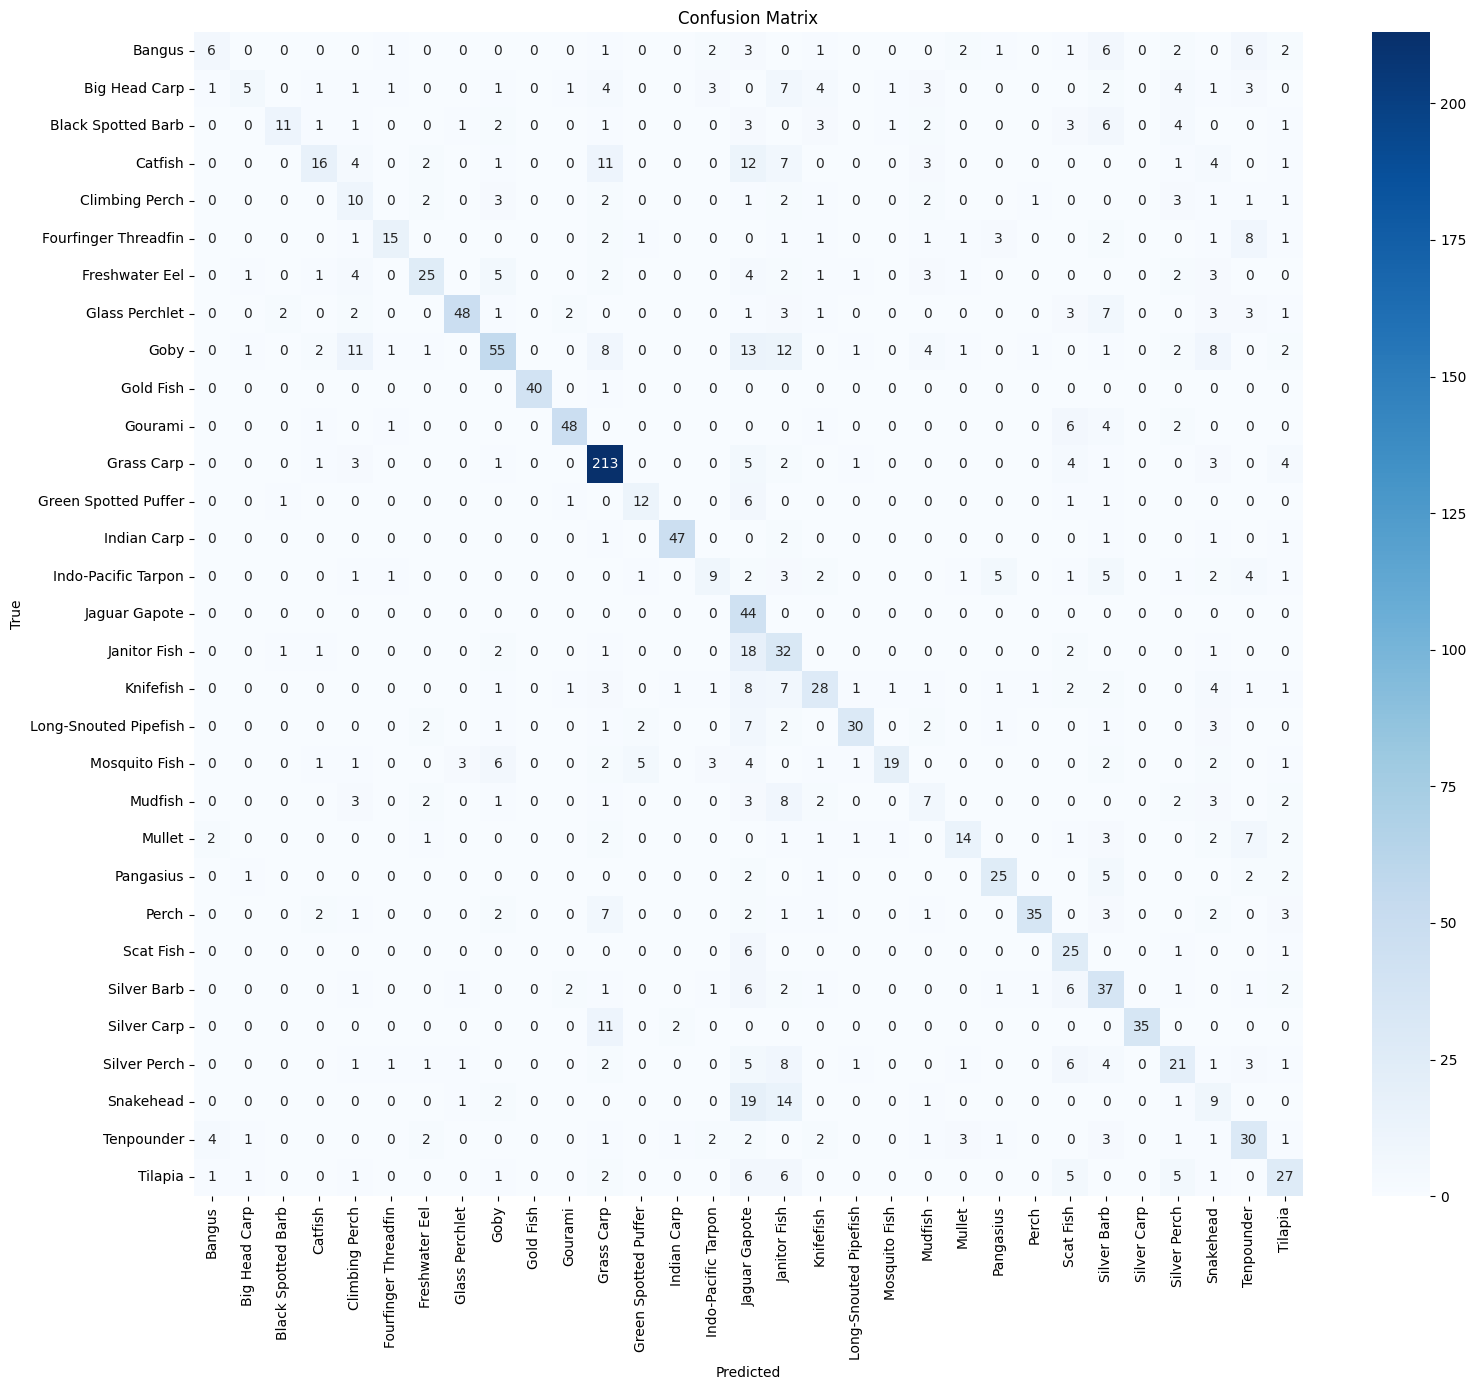

In [ ]:
plt.figure(figsize=(16, 14))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

#CNN using Fine tuning

In [326]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from itertools import cycle
import warnings
warnings.filterwarnings('ignore')

In [312]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

## Data Preperation

In [287]:
dataset_path = 'C:/Users/Maru/Documents/FishImgDataset'
train_dir = os.path.join(dataset_path, 'train')
val_dir = os.path.join(dataset_path, 'val')
test_dir = os.path.join(dataset_path, 'test')

In [288]:
IMG_SIZE = 84
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

In [289]:
class_counts = {
    'Train': [171, 201, 200, 314, 152, 192, 273, 399, 607, 206, 312, 1222, 110, 262, 186, 229, 286, 319, 256, 256, 191, 174, 193, 293, 154, 329, 238, 285, 232, 277, 302],
    'Validation': [52, 63, 63, 97, 48, 60, 84, 124, 189, 65, 97, 378, 34, 81, 57, 72, 89, 100, 81, 80, 60, 55, 61, 91, 48, 105, 75, 88, 72, 87, 95],
    'Test': [34, 43, 40, 62, 30, 38, 55, 77, 124, 41, 63, 238, 22, 53, 39, 44, 58, 65, 52, 51, 34, 38, 38, 60, 33, 64, 48, 57, 47, 56, 57]
}

In [290]:
train_counts_list = class_counts['Train']
max_samples = max(train_counts_list)
class_weights = {i: float(max_samples) / float(count) for i, count in enumerate(train_counts_list)}


##Data augmentation

In [291]:
print({k: type(v) for k, v in class_weights.items()})

{0: <class 'float'>, 1: <class 'float'>, 2: <class 'float'>, 3: <class 'float'>, 4: <class 'float'>, 5: <class 'float'>, 6: <class 'float'>, 7: <class 'float'>, 8: <class 'float'>, 9: <class 'float'>, 10: <class 'float'>, 11: <class 'float'>, 12: <class 'float'>, 13: <class 'float'>, 14: <class 'float'>, 15: <class 'float'>, 16: <class 'float'>, 17: <class 'float'>, 18: <class 'float'>, 19: <class 'float'>, 20: <class 'float'>, 21: <class 'float'>, 22: <class 'float'>, 23: <class 'float'>, 24: <class 'float'>, 25: <class 'float'>, 26: <class 'float'>, 27: <class 'float'>, 28: <class 'float'>, 29: <class 'float'>, 30: <class 'float'>}


In [292]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

In [310]:
def visualize_augmentation(dataset_path, class_names, num_samples=5):
    plt.figure(figsize=(20, 20))
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
    ])

    for i, fish_type in enumerate(class_names[:min(5, len(class_names))]):
        sample_dir = os.path.join(dataset_path, fish_type)
        if os.path.isdir(sample_dir):
            sample_files = os.listdir(sample_dir)[:1]  # Take 1 image per class
            for j, file in enumerate(sample_files):
                img_path = os.path.join(sample_dir, file)
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
                x = tf.keras.preprocessing.image.img_to_array(img)
                x = x.reshape((1,) + x.shape)

                # Original image
                plt.subplot(len(class_names[:min(5, len(class_names))]),
                            num_samples + 1,
                            i * (num_samples + 1) + 1)
                plt.imshow(img)
                plt.title(f"Original: {fish_type}")
                plt.axis('off')

                # Augmented images
                for k in range(num_samples):
                    augm_img = data_augmentation(x, training=True)[0].numpy()
                    augm_img = np.clip(augm_img, 0, 255).astype('uint8')
                    plt.subplot(len(class_names[:min(5, len(class_names))]),
                                num_samples + 1,
                                i * (num_samples + 1) + k + 2)
                    plt.imshow(augm_img)
                    plt.title(f"Augmented {k+1}")
                    plt.axis('off')
                break

    plt.tight_layout()
    plt.savefig('data_augmentation_samples.png')
    plt.show()

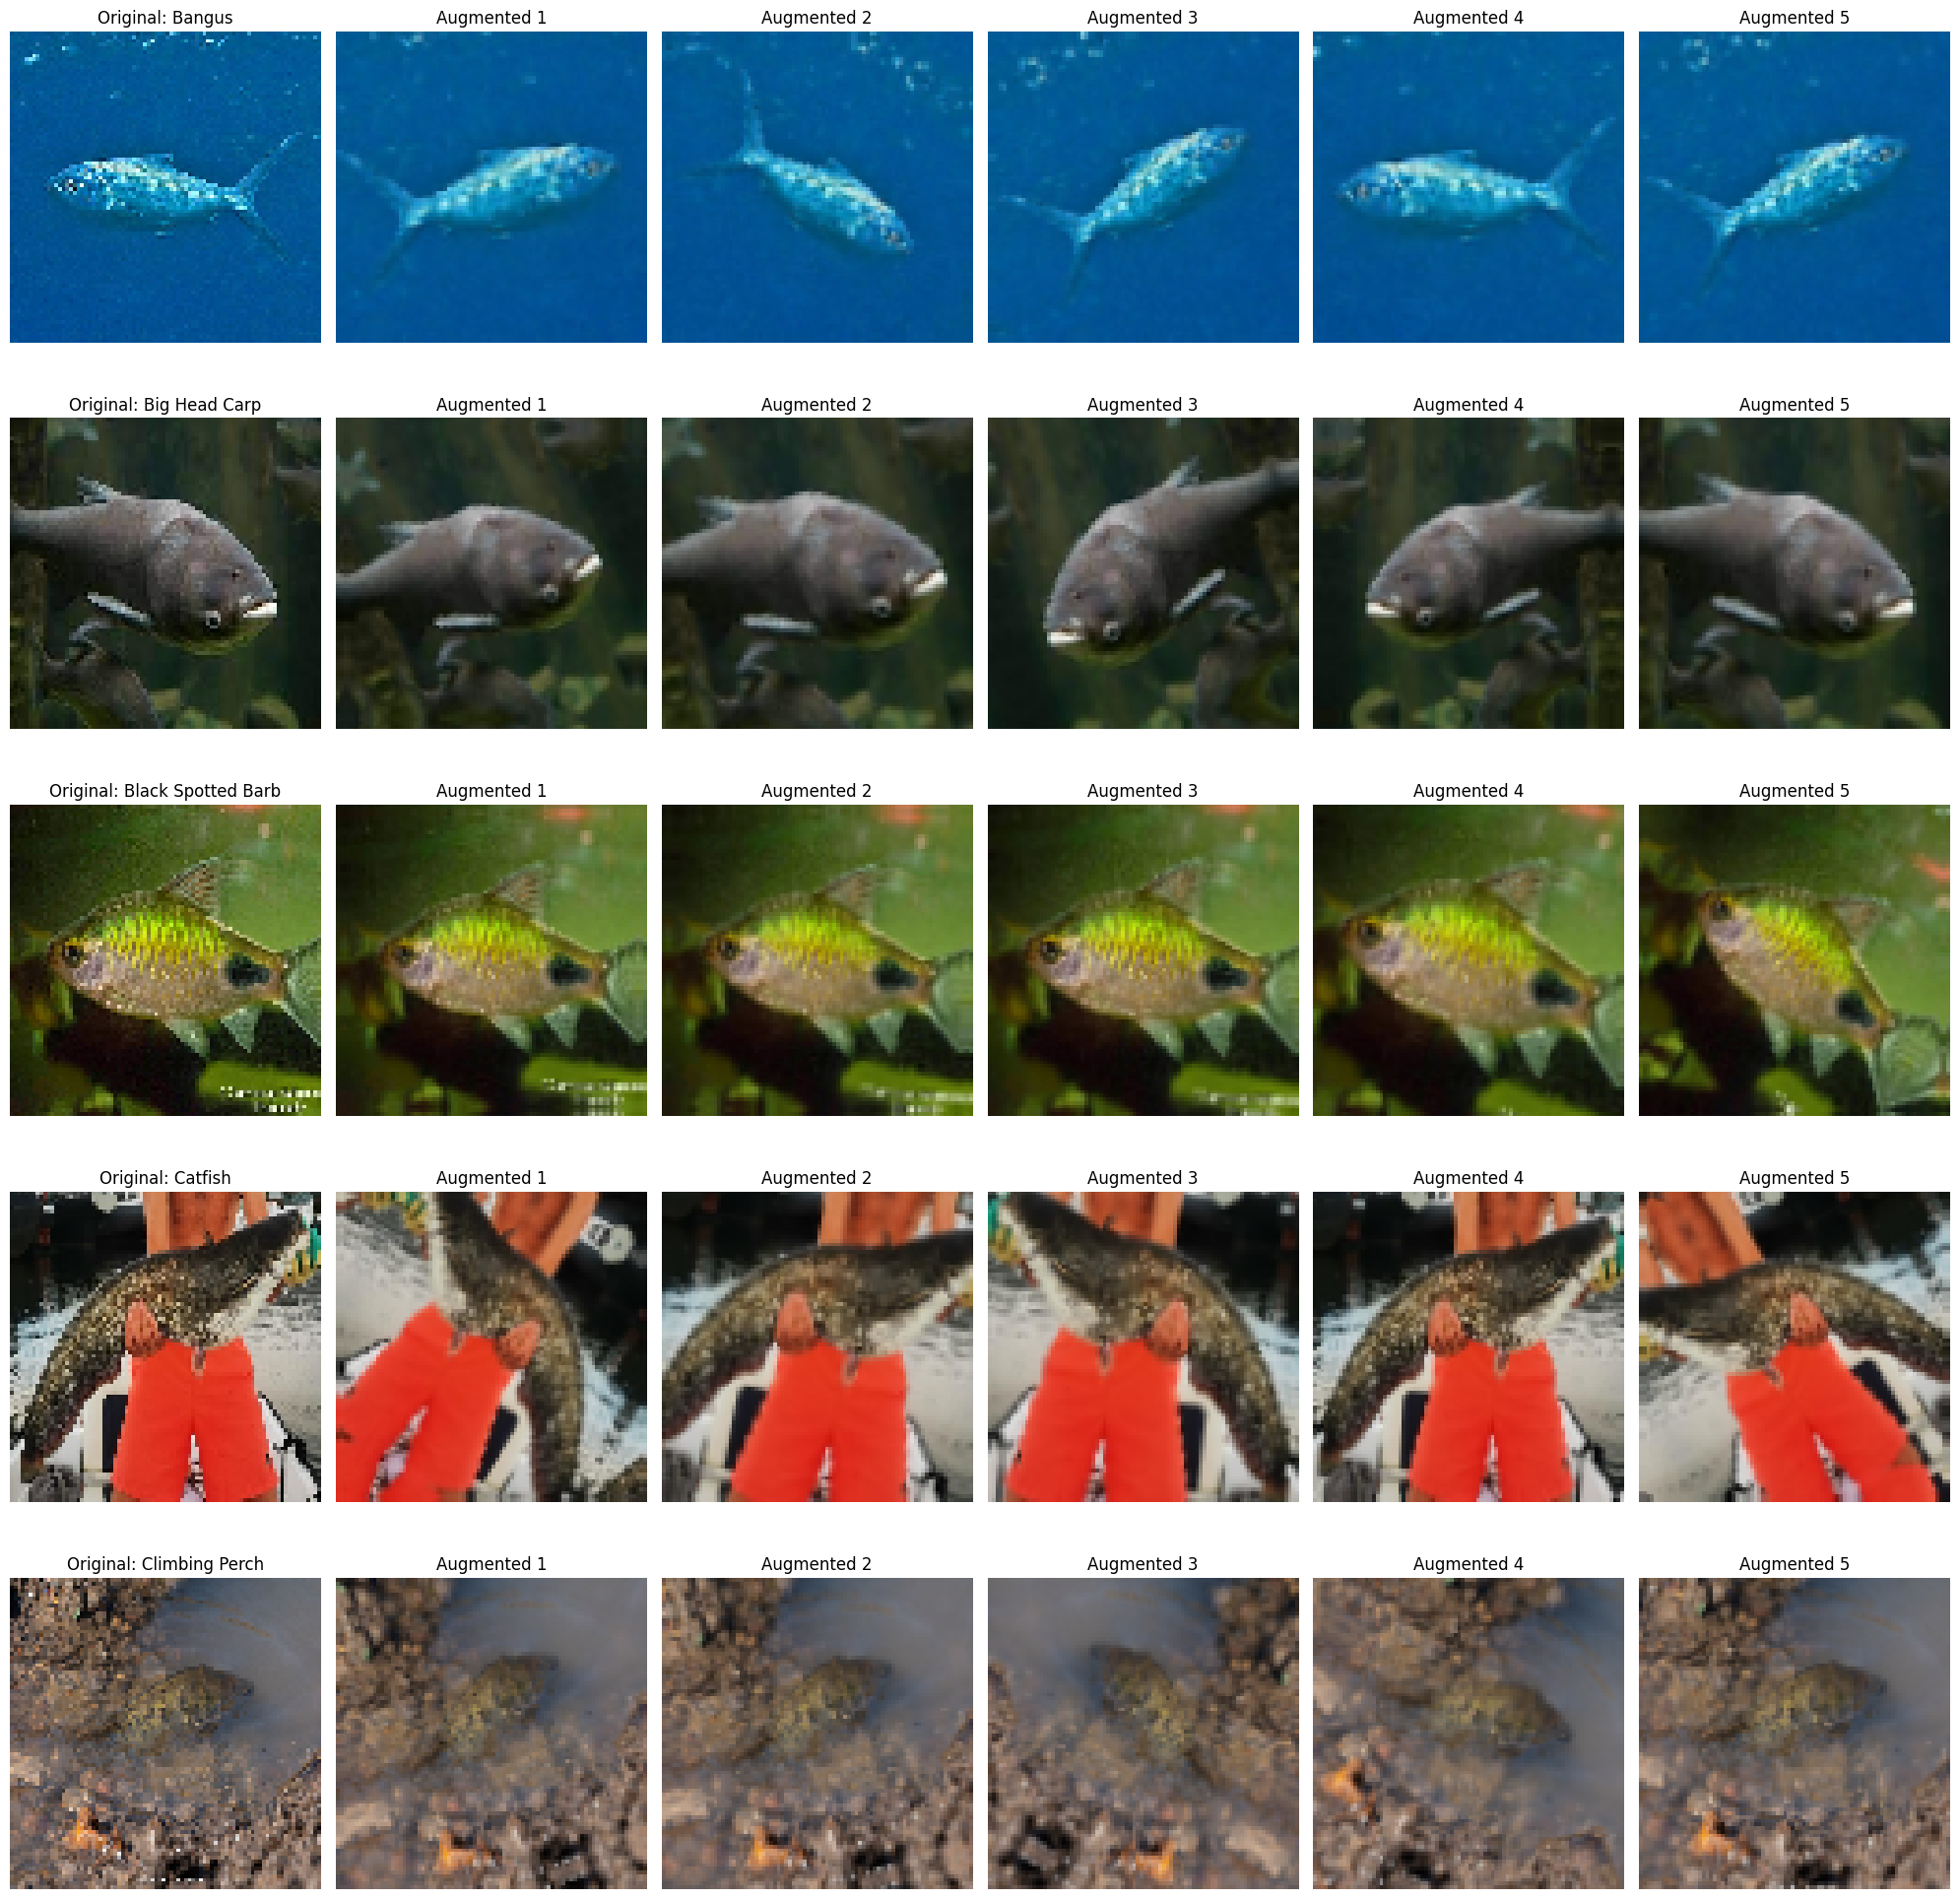

In [313]:
visualize_augmentation(train_dir, class_names)

In [293]:
def prepare_dataset(directory, augment=False):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        label_mode='int'
    )
    class_names = dataset.class_names
    if augment:
        dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y))
    dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
    return dataset, class_names

In [314]:
train_ds, class_names = prepare_dataset(train_dir, augment=True)
val_ds, _ = prepare_dataset(val_dir)
test_ds, _ = prepare_dataset(test_dir)

Found 8819 files belonging to 31 classes.
Found 2751 files belonging to 31 classes.
Found 1761 files belonging to 31 classes.


In [295]:
num_classes = len(class_names)

##Modeling cnn

In [296]:
def create_model(num_classes):
    base_model = EfficientNetB0(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model, base_model

In [297]:
model, base_model = create_model(num_classes)

In [298]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=True)
]

In [299]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 1/20
138/138 [==============================] - 58s 359ms/step - loss: 11.4844 - accuracy: 0.2894 - val_loss: 1.7415 - val_accuracy: 0.5736
Epoch 2/20
138/138 [==============================] - 11s 82ms/step - loss: 7.7326 - accuracy: 0.5134 - val_loss: 1.3806 - val_accuracy: 0.6514
Epoch 3/20
138/138 [==============================] - 11s 76ms/step - loss: 6.6341 - accuracy: 0.5741 - val_loss: 1.2172 - val_accuracy: 0.6808
Epoch 4/20
138/138 [==============================] - 11s 80ms/step - loss: 6.0291 - accuracy: 0.6040 - val_loss: 1.1164 - val_accuracy: 0.7088
Epoch 5/20
138/138 [==============================] - 11s 77ms/step - loss: 5.5938 - accuracy: 0.6268 - val_loss: 1.0400 - val_accuracy: 0.7237
Epoch 6/20
138/138 [==============================] - 9s 63ms/step - loss: 5.2739 - accuracy: 0.6429 - val_loss: 1.0027 - val_accuracy: 0.7248
Epoch 7/20
138/138 [==============================] - 10s 69ms/step - loss: 4.9984 - accuracy: 0.6598 - val_loss: 0.9661 - val_accuracy

In [300]:
base_model.trainable = True
for layer in base_model.layers[:50]:
    layer.trainable = False

In [301]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [302]:
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=callbacks
)

Epoch 1/15
138/138 [==============================] - 52s 284ms/step - loss: 1.8592 - accuracy: 0.5097 - val_loss: 0.9030 - val_accuracy: 0.7405
Epoch 2/15
138/138 [==============================] - 36s 264ms/step - loss: 0.9955 - accuracy: 0.7057 - val_loss: 0.8031 - val_accuracy: 0.7648
Epoch 3/15
138/138 [==============================] - 37s 271ms/step - loss: 0.6664 - accuracy: 0.7956 - val_loss: 0.7252 - val_accuracy: 0.7844
Epoch 4/15
138/138 [==============================] - 37s 268ms/step - loss: 0.4966 - accuracy: 0.8457 - val_loss: 0.6501 - val_accuracy: 0.8066
Epoch 5/15
138/138 [==============================] - 37s 268ms/step - loss: 0.3566 - accuracy: 0.8925 - val_loss: 0.6038 - val_accuracy: 0.8222
Epoch 6/15
138/138 [==============================] - 37s 268ms/step - loss: 0.2908 - accuracy: 0.9096 - val_loss: 0.5783 - val_accuracy: 0.8332
Epoch 7/15
138/138 [==============================] - 37s 268ms/step - loss: 0.2184 - accuracy: 0.9365 - val_loss: 0.5414 - val_ac

In [303]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

28/28 [==============================] - 6s 151ms/step - loss: 0.4686 - accuracy: 0.8739

Test Accuracy: 0.8739
Test Loss: 0.4686


In [317]:
y_true = []
y_pred_probs = []
for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred_probs.extend(preds)

y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_true, y_pred, target_names=class_names))

2/2 [==============================] - 0s 41ms/step
                       precision    recall  f1-score   support

               Bangus       0.55      0.82      0.66        34
        Big Head Carp       0.82      0.86      0.84        43
   Black Spotted Barb       0.97      0.80      0.88        40
              Catfish       0.82      0.94      0.87        62
       Climbing Perch       0.79      0.63      0.70        30
 Fourfinger Threadfin       0.94      0.79      0.86        38
       Freshwater Eel       0.91      0.91      0.91        55
       Glass Perchlet       0.94      0.95      0.94        77
                 Goby       0.90      0.91      0.91       124
            Gold Fish       1.00      1.00      1.00        41
              Gourami       0.93      0.90      0.92        63
           Grass Carp       0.85      0.98      0.91       238
 Green Spotted Puffer       1.00      0.95      0.98        22
          Indian Carp       1.00      0.87      0.93        53
  

In [318]:
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

In [319]:
print("Hasil evaluasi:")
print(f"Accuracy: {report['accuracy']:.4f}")
print(f"Precision: {report['weighted avg']['precision']:.4f}")  # Access precision from 'weighted avg'
print(f"Recall: {report['weighted avg']['recall']:.4f}")  # Access recall from 'weighted avg'
print(f"F1 Score: {report['weighted avg']['f1-score']:.4f}")  # Access F1-score from 'weighted avg'

Hasil evaluasi:
Accuracy: 0.8739
Precision: 0.8809
Recall: 0.8739
F1 Score: 0.8733


## Visulize

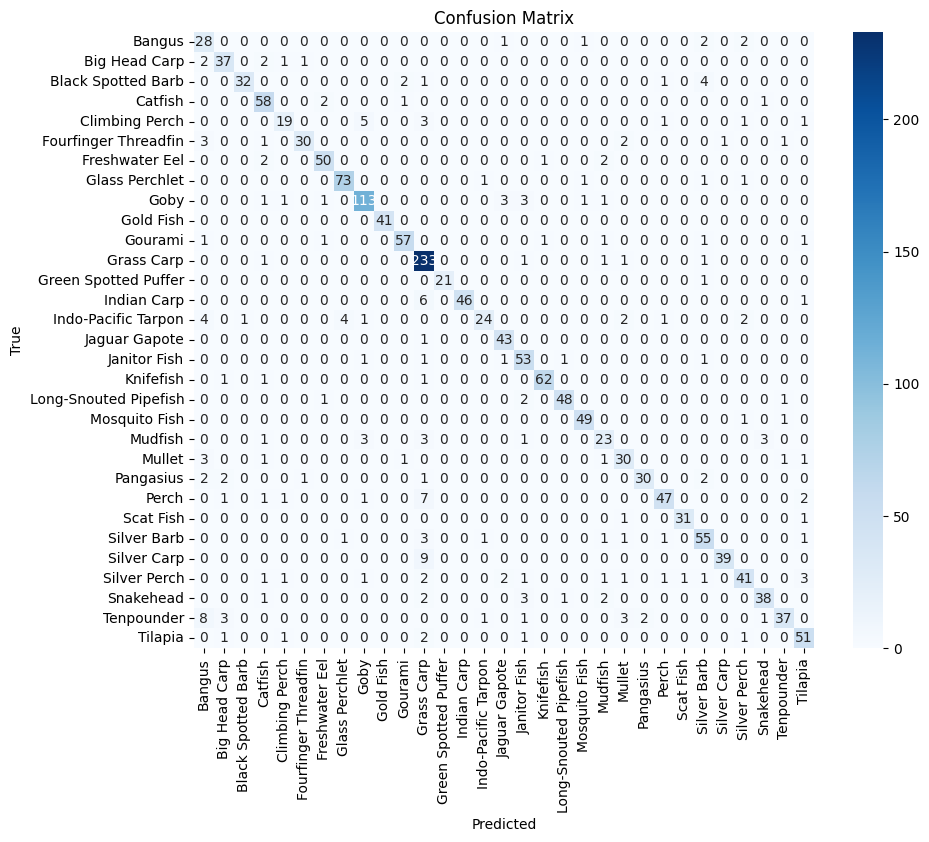

In [320]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

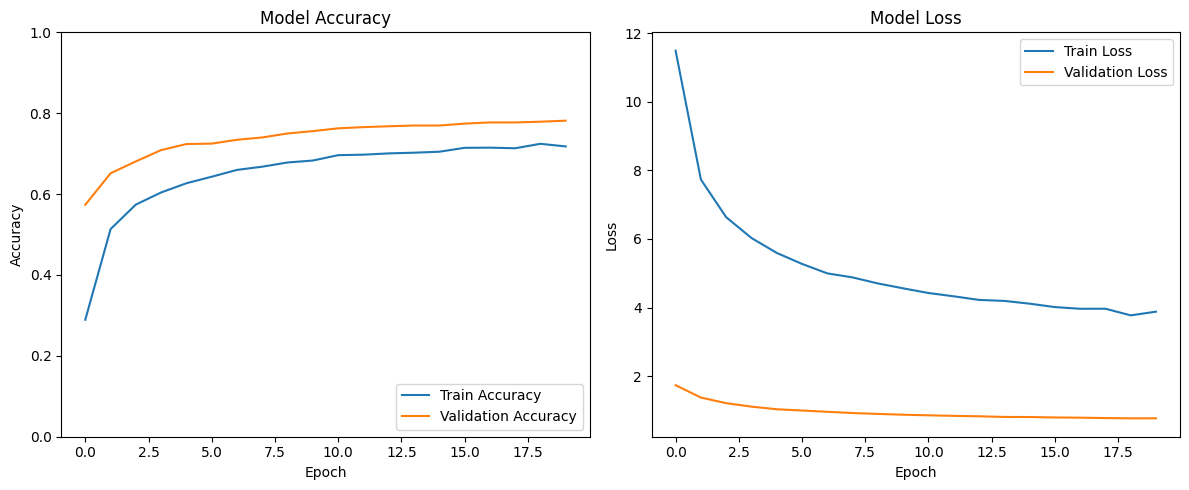

In [330]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.ylim([0, 1])  # Set y-axis limits between 0 and 1
    plt.legend(loc='lower right')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300)
    plt.show()

plot_training_history(history)

In [328]:
def plot_individual_roc_curves(y_true, y_pred_probs, class_names, top_n=5):
    # Binarize the output
    y_true = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Get top N classes with highest AUC
    top_classes = sorted(range(num_classes), key=lambda i: roc_auc[i], reverse=True)[:top_n]

    # Plot individual ROC curves
    plt.figure(figsize=(15, 12))

    for idx, i in enumerate(top_classes):
        plt.subplot(3, 2, idx+1)  # 3 rows, 2 columns layout
        plt.plot(fpr[i], tpr[i], color='darkorange', lw=2,
                 label='ROC curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC for {class_names[i]}')
        plt.legend(loc="lower right")

    plt.tight_layout()
    plt.savefig('individual_roc_curves.png')
    plt.show()

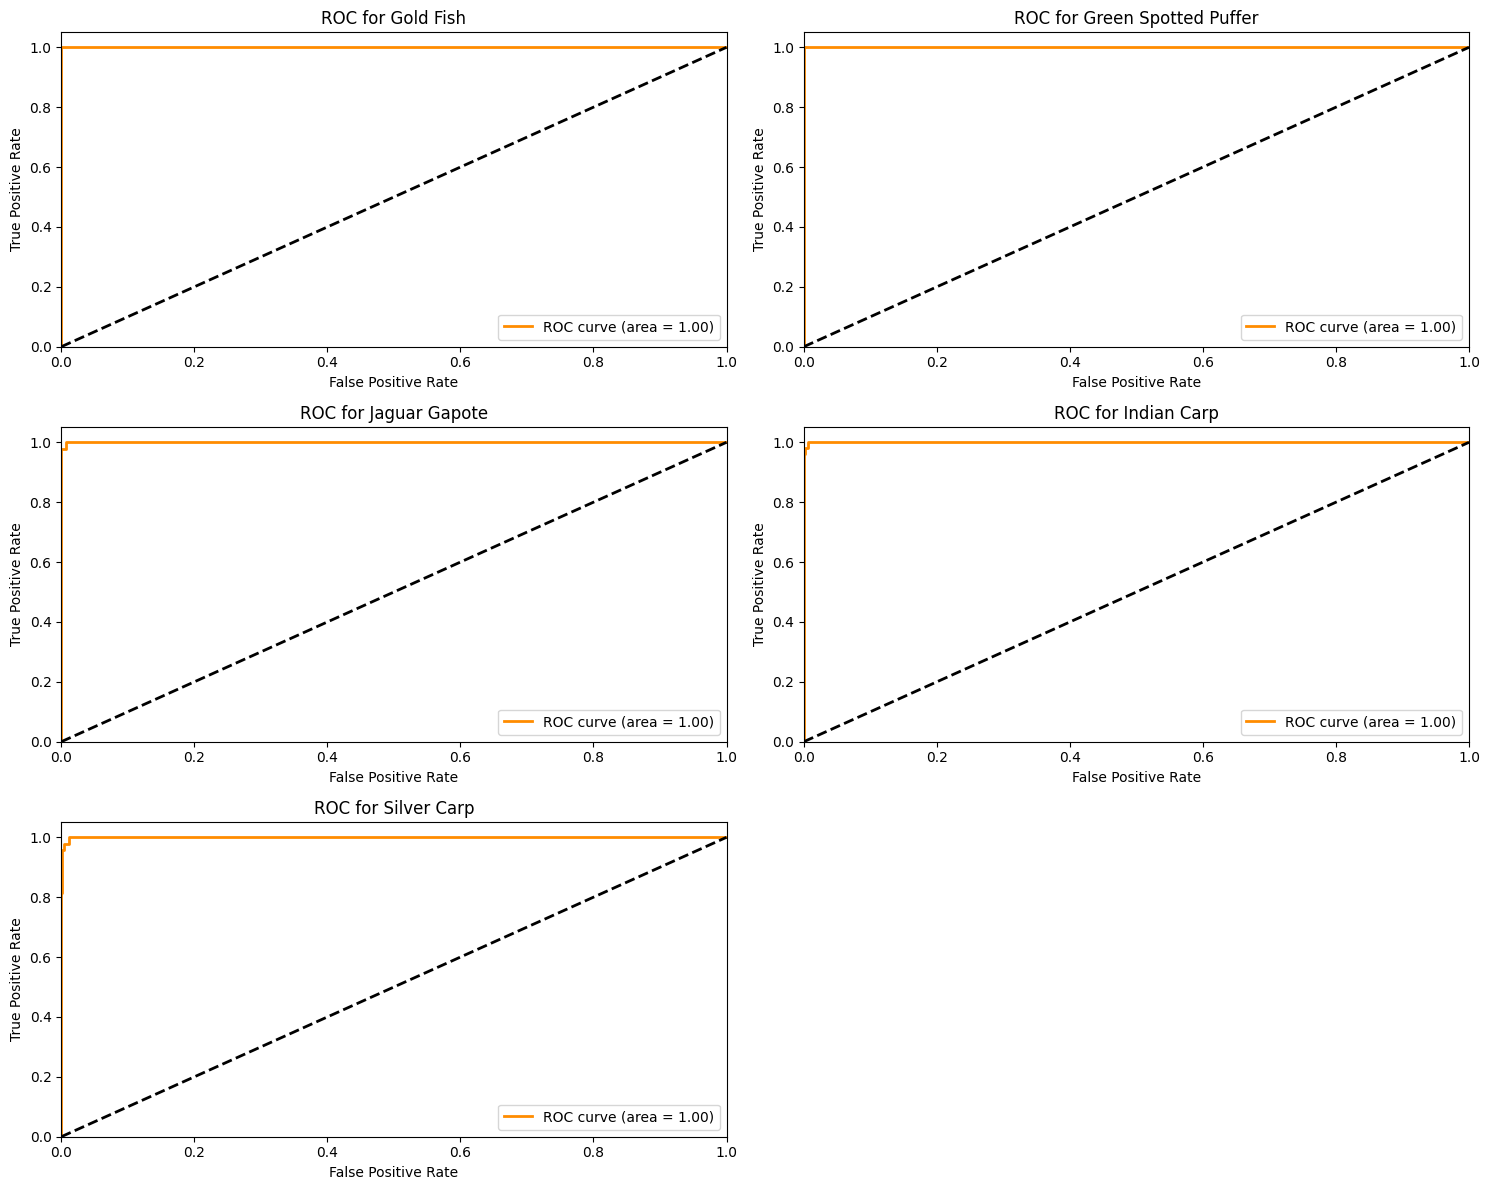

In [329]:
plot_individual_roc_curves(y_true, np.array(y_pred_probs), class_names, top_n=5)

## Pemodelan Klasifikasi Ikan CNN

## 1. Model CNN

### 1.1 Convolutional Neural Network (CNN)

CNN adalah jenis jaringan saraf tiruan yang dirancang khusus untuk pemrosesan data dengan struktur grid, seperti citra. Arsitektur CNN terdiri dari beberapa komponen utama:

#### a. Convolutional Layer

Lapisan konvolusi mengekstrak fitur dari citra input dengan menggunakan filter (kernel). Operasi konvolusi dapat dinyatakan sebagai:

$$S(i,j) = (I * K)(i,j) = \sum_m \sum_n I(i+m, j+n) \cdot K(m,n)$$

dimana:
- $S(i,j)$ adalah hasil konvolusi pada posisi $(i,j)$
- $I$ adalah citra input
- $K$ adalah kernel
- $m$ dan $n$ adalah dimensi kernel

Setiap filter menghasilkan activation map yang menunjukkan di mana fitur terdeteksi dalam citra.

#### b. Pooling Layer

Pooling layer mengurangi dimensi representasi dengan down-sampling. Max pooling dan average pooling adalah jenis pooling yang umum digunakan:

**Max Pooling:**
$$y_{i,j} = \max_{0 \leq m,n < s} x_{i \cdot s + m, j \cdot s + n}$$

**Average Pooling:**
$$y_{i,j} = \frac{1}{s^2} \sum_{0 \leq m,n < s} x_{i \cdot s + m, j \cdot s + n}$$

dimana $s$ adalah ukuran stride.

#### c. Fully Connected Layer

Lapisan ini menghubungkan semua neuron dari lapisan sebelumnya ke lapisan berikutnya dan melakukan klasifikasi berdasarkan fitur yang diekstrak.

### 1.2 Activation Function

#### a. ReLU (Rectified Linear Unit)

$$f(x) = \max(0, x)$$

ReLU menggantikan semua nilai negatif dengan nol, memungkinkan pelatihan yang lebih cepat dan mengatasi masalah vanishing gradient.

#### b. Softmax

Softmax digunakan pada lapisan output untuk multi-kelas klasifikasi:

$$\sigma(z)_j = \frac{e^{z_j}}{\sum_{k=1}^{K} e^{z_k}}$$

dimana $z_j$ adalah input ke fungsi softmax untuk kelas $j$, dan $K$ adalah jumlah kelas.

## 2. Transfer Learning dengan EfficientNetB0

### 2.1 Arsitektur EfficientNet

EfficientNet adalah keluarga model CNN yang mengoptimalkan efisiensi komputasi dengan metode scaling model. EfficientNetB0 adalah model dasar yang menggunakan MBConv (Mobile Inverted Bottleneck Convolution) blok:

$y = \mathcal{F}(x, \theta) + x$

dimana $\mathcal{F}$ adalah fungsi residual yang dipelajari dan $\theta$ adalah parameter.

#### Compound Scaling Method

EfficientNet menggunakan compound scaling method yang menskalakan dimensi jaringan (kedalaman, lebar, dan resolusi) secara bersamaan dengan formula:

$\text{depth}: d = \alpha^\phi$
$\text{width}: w = \beta^\phi$
$\text{resolution}: r = \gamma^\phi$

dimana $\alpha, \beta, \gamma$ adalah koefisien yang ditemukan melalui grid search, dan $\phi$ adalah koefisien scaling yang mengontrol sumber daya komputasi yang tersedia.

### 2.2 Prinsip Transfer Learning

Transfer learning memanfaatkan pengetahuan dari model pre-trained untuk meningkatkan performa pada dataset baru:

1. **Feature Extraction**: Menggunakan base model yang telah dilatih pada dataset besar (ImageNet) dengan bobot yang dibekukan (frozen)
2. **Fine-tuning**: Melatih kembali beberapa lapisan terakhir untuk menyesuaikan model dengan dataset spesifik

### 2.3 Fine-tuning Detail

Fine-tuning adalah teknik untuk menyesuaikan model pre-trained agar lebih baik dengan domain target (dalam kasus ini, klasifikasi ikan). Proses ini melibatkan:

#### a. Tahap Pelatihan Dua Fase

1. **Fase 1 (Feature Extraction)**:
   - Membekukan seluruh base model (`base_model.trainable = False`)
   - Melatih hanya lapisan yang baru ditambahkan (GlobalAveragePooling2D, Dropout, dan Dense)
   - Menggunakan learning rate yang lebih tinggi (1e-3)
   - Formula update: $\theta_{\text{new}} = \theta_{\text{new}} - \eta \nabla_{\theta_{\text{new}}} \mathcal{L}(\theta)$

2. **Fase 2 (Fine-tuning)**:
   - Membekukan sebagian lapisan awal (`for layer in base_model.layers[:50]: layer.trainable = False`)
   - Membuka lapisan-lapisan terakhir untuk dilatih (`base_model.trainable = True`)
   - Menggunakan learning rate yang lebih rendah (1e-4) untuk mencegah overfitting
   - Formula update: $\theta_{\text{fine}} = \theta_{\text{fine}} - \eta' \nabla_{\theta_{\text{fine}}} \mathcal{L}(\theta)$

dimana $\eta > \eta'$ (learning rate fase 1 > learning rate fase 2)

#### b. Discriminative Learning Rates

Pendekatan fine-tuning menggunakan discriminative learning rates dimana:
- Lapisan baru yang ditambahkan: Learning rate lebih tinggi
- Lapisan pre-trained yang di-fine-tune: Learning rate lebih rendah

Intuisi: Lapisan awal mendeteksi fitur-fitur umum (tepi, tekstur) yang umumnya berguna pada semua jenis gambar, sementara lapisan terakhir mendeteksi fitur spesifik domain.

#### c. Regularisasi

Selama fine-tuning, regularisasi penting untuk mencegah overfitting:
- Dropout (0.5) diterapkan sebelum lapisan klasifikasi
- Early stopping diterapkan dengan parameter patience=5
- ModelCheckpoint untuk menyimpan model terbaik

#### d. Formulasi Matematis Feature Transfer

Jika $\phi_{\text{ImageNet}}$ dan $\phi_{\text{Fish}}$ adalah distribusi fitur untuk domain ImageNet dan domain ikan, transfer learning berusaha untuk memetakan:

$\mathcal{T}: \phi_{\text{ImageNet}} \rightarrow \phi_{\text{Fish}}$

dengan fine-tuning meminimalkan jarak distribusi:

$\min_{\theta} \mathcal{D}(\phi_{\text{Fish}}, \mathcal{T}(\phi_{\text{ImageNet}}; \theta))$

dimana $\mathcal{D}$ adalah metrik jarak dan $\theta$ adalah parameter yang dapat dilatih.

## 4. Data Augmentation

Data augmentation meningkatkan variasi data pelatihan dengan transformasi citra:

1. **Random Flip**: Membalik citra secara horizontal
2. **Random Rotation**: Merotasi citra dengan sudut acak ($\theta$)
3. **Random Zoom**: Memperbesar atau memperkecil citra dengan faktor acak

Augmentasi data membantu mengurangi overfitting dan meningkatkan generalisasi model.

## 5. Class Imbalance Handling

### 5.1 Class Weighting

Untuk mengatasi ketidakseimbangan kelas, bobot kelas dihitung dengan formula:

$$w_i = \frac{\max(n_1, n_2, ..., n_k)}{n_i}$$

dimana:
- $w_i$ adalah bobot untuk kelas $i$
- $n_i$ adalah jumlah sampel dalam kelas $i$
- $\max(n_1, n_2, ..., n_k)$ adalah jumlah sampel maksimum di antara semua kelas

## 6. Loss Function

### 6.1 Sparse Categorical Cross-entropy

Loss function untuk klasifikasi multi-kelas:

$$\mathcal{L}(y, \hat{y}) = -\sum_{i=1}^{N} \sum_{c=1}^{C} y_{i,c} \log(\hat{y}_{i,c})$$

dimana:
- $y_{i,c}$ adalah label sebenarnya (1 jika sampel $i$ adalah kelas $c$, 0 jika tidak)
- $\hat{y}_{i,c}$ adalah probabilitas prediksi dari model
- $N$ adalah jumlah sampel
- $C$ adalah jumlah kelas

## 7. Optimization Algorithm

### 7.1 Adam Optimizer

Adam (Adaptive Moment Estimation) menggabungkan keuntungan dari AdaGrad dan RMSProp:

$$m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t$$
$$v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2$$
$$\hat{m}_t = \frac{m_t}{1 - \beta_1^t}$$
$$\hat{v}_t = \frac{v_t}{1 - \beta_2^t}$$
$$\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{\hat{v}_t} + \epsilon} \hat{m}_t$$

dimana:
- $m_t$ adalah estimasi momen pertama (mean)
- $v_t$ adalah estimasi momen kedua (variance)
- $g_t$ adalah gradien pada waktu $t$
- $\beta_1$ dan $\beta_2$ adalah hyperparameter decay rates
- $\eta$ adalah learning rate
- $\epsilon$ adalah nilai kecil untuk mencegah pembagian dengan nol

## 8. Evaluasi Model

### 8.1 Metrics

#### a. Accuracy

$$\text{Accuracy} = \frac{\text{Number of correct predictions}}{\text{Total number of predictions}} = \frac{TP + TN}{TP + TN + FP + FN}$$

#### b. Precision

$$\text{Precision} = \frac{TP}{TP + FP}$$

#### c. Recall

$$\text{Recall} = \frac{TP}{TP + FN}$$

#### d. F1 Score

$$\text{F1} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$$

#### e. Area Under ROC Curve (AUC-ROC)

AUC-ROC mengevaluasi kemampuan model untuk membedakan antar kelas:

$$\text{AUC} = \int_{0}^{1} TPR(FPR^{-1}(f))df$$

dimana:
- TPR (True Positive Rate) = Recall = $\frac{TP}{TP+FN}$
- FPR (False Positive Rate) = $\frac{FP}{FP+TN}$
